In [1]:
from IPython.display import Image, display
Image('images/09_transfer_learning_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

In [3]:
tf.__version__

'1.2.1'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data

In [5]:
import knifey

In [6]:
from knifey import num_classes

In [7]:
knifey.data_dir = "data/resize"

In [8]:
data_dir = knifey.data_dir

In [9]:
#knifey.maybe_download_and_extract()

In [10]:
dataset = knifey.load()

Creating dataset from the files in: data/resize
- Data loaded from cache-file: data/resize\knifey-spoony.pkl


In [11]:
# from dataset import load_cached
# dataset = load_cached(cache_path='my_dataset_cache.pkl', in_dir='my_images/')
# num_classes = dataset.num_classes

### Training and Test-Sets

In [12]:
class_names = dataset.class_names
class_names

['ads', 'sports']

In [13]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

In [14]:
image_paths_train[0]

'C:\\Users\\basit\\notebook\\FYP\\filter\\data\\resize\\ads\\image0.jpg'

Get the test-set.

In [15]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

In [16]:
image_paths_test[0]

'C:\\Users\\basit\\notebook\\FYP\\filter\\data\\resize\\ads\\test/image100.jpg'

In [17]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		14999
- Test-set:		2997


### Helper-function for plotting images

In [18]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for loading images

In [19]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Plot a few images to see if data is correct

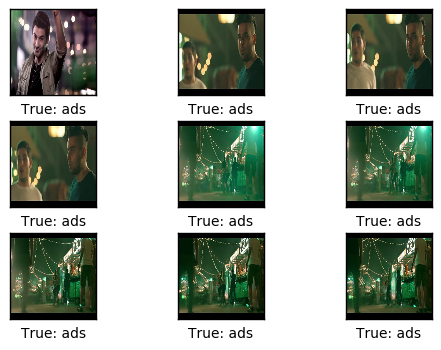

In [20]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

## Download the Inception Model

In [21]:
inception.data_dir = 'inception/'

In [22]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Load the Inception Model

In [23]:
model = inception.Inception()

## Calculate Transfer-Values

In [24]:
from inception import transfer_values_cache

In [25]:
file_path_cache_train = os.path.join(data_dir, 'inception-ads-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-ads-test.pkl')

In [26]:
print("Processing Inception transfer-values for training-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: data/resize\inception-ads-train.pkl


In [27]:
print("Processing Inception transfer-values for test-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: data/resize\inception-ads-test.pkl


In [28]:
transfer_values_train.shape

(14999, 2048)

### Helper-function for plotting transfer-values

In [29]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


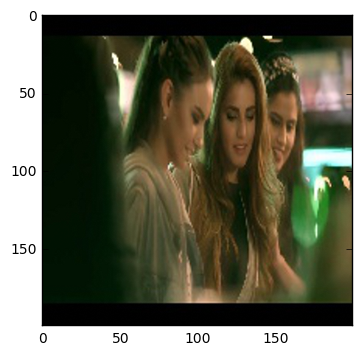

Transfer-values for the image using Inception model:


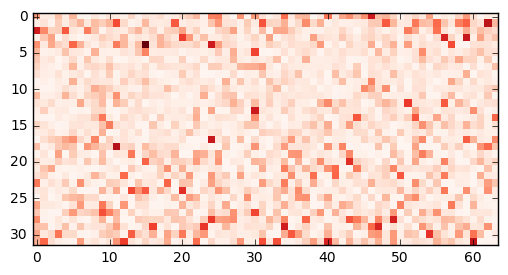

In [30]:
plot_transfer_values(i=50)

Input image:


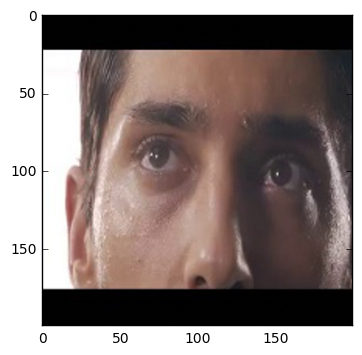

Transfer-values for the image using Inception model:


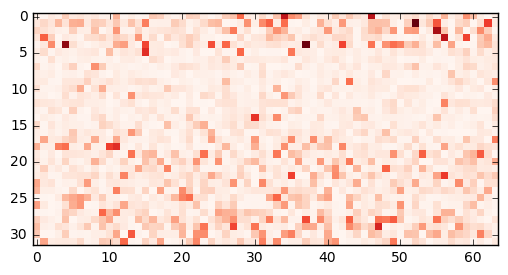

In [31]:
plot_transfer_values(i=350)

## Analysis of Transfer-Values using PCA

.

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=2)

In [34]:
transfer_values = transfer_values_train[0:3000]
#transfer_values = transfer_values_train

In [35]:
cls = cls_train[0:3000]
#cls = cls_train

In [36]:
transfer_values.shape

(3000, 2048)

In [37]:
transfer_values_reduced = pca.fit_transform(transfer_values)

In [38]:
transfer_values_reduced.shape

(3000, 2)

Helper-function for plotting the reduced transfer-values.

In [39]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Create an index with a random permutation to make a better plot.
    idx = np.random.permutation(len(values))
    
    # Get the color for each sample.
    colors = cmap[cls[idx]]

    # Extract the x- and y-values.
    x = values[idx, 0]
    y = values[idx, 1]

    # Plot it.
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

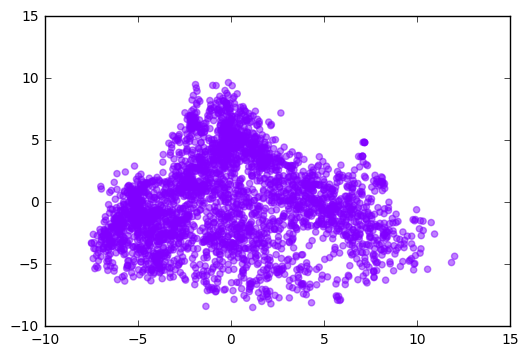

In [40]:
plot_scatter(transfer_values_reduced, cls=cls)

## Analysis of Transfer-Values using t-SNE

In [41]:
from sklearn.manifold import TSNE

In [42]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

In [43]:
tsne = TSNE(n_components=2)

In [44]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)

In [45]:
transfer_values_reduced.shape

(3000, 2)

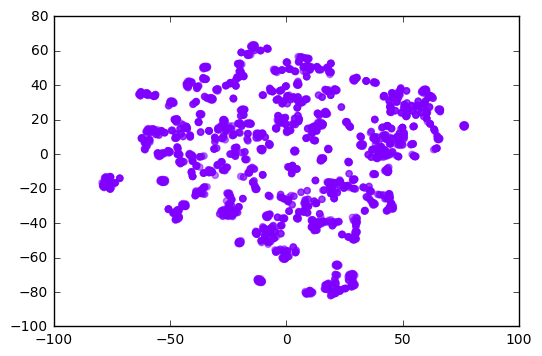

In [46]:
plot_scatter(transfer_values_reduced, cls=cls)

## New Classifier in TensorFlow

### Placeholder Variables

In [47]:
transfer_len = model.transfer_len

In [48]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

In [49]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [50]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

In [51]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        fully_connected(size=512, name='layer_fc2').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Optimization Method

In [52]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

In [54]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [55]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [56]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow Session

In [57]:
session = tf.Session()

### Initialize Variables

In [58]:
session.run(tf.global_variables_initializer())

### Helper-function to get a random training-batch

In [59]:
train_batch_size = 64

In [60]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Helper-function to perform optimization

In [61]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-Functions for Showing Results

### Helper-function to plot example errors

In [62]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the indices for the incorrectly classified images.
    idx = np.flatnonzero(incorrect)

    # Number of images to select, max 9.
    n = min(len(idx), 9)
    
    # Randomize and select n indices.
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # Get the predicted classes for those images.
    cls_pred = cls_pred[idx]

    # Get the true classes for those images.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # Note: We cannot do image_paths_test[idx] on lists of strings.
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # Plot the images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

### Helper-function to plot confusion matrix

In [63]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [64]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 32

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [65]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [66]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the classification accuracy

In [67]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Results

In [68]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 51.3% (1536 / 2997)
Confusion Matrix:
[859 638] (0) ads
[823 677] (1) sports
 (0) (1)


In [71]:
optimize(num_iterations=600)

In [73]:
print_test_accuracy()

Accuracy on Test-Set: 60.0% (1799 / 2997)
